### Parte 1

Importar las bibliotecas que son usadas en el desarrollo del laboratorio

In [1]:
#Usar Python 3.7

In [1]:
#pip install d2l==0.17.1

In [2]:
#pip install matplotlib==3.1.3

In [3]:
#conda install tensorflow

In [4]:
#pip install 'h5py==2.10.0' --force-reinstall

In [1]:
#Bibliotecas propias
%matplotlib inline
import os,os.path,math,scipy
import PIL

from datasets import ClassLabel

#Bibliotecas para LeNet
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time


import torchvision
from torch import nn
from d2l import torch as d2l

import tensorflow as tf


In [2]:
#Se setean las seeds
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
### Escribir en estos bloques el codigo de acorde a las instrucciones planteadas
### pero no olvide que puede crear los bloques que quiera y puede agregar las sub secciones 
### que deseen, esto es solo una guía basica

Lectura del conjunto de datos, deberá diseñar una estrategia para la selección y lectura del sub conjunto de datos, es decir, se debe crear un conjuntos de datos pequeño que contenga entre 3 a 5 clases y una cantidad de $N$ ejemplos para cada clase, con el fin de tener un conjunto de datos balanceado con un tamaño que se pueda trabajar con los recursos disponibles.

In [4]:
def same_amount_of_n_images(img_dir_list, N):
    for img_dir in img_dir_list:
        img_count = len([name for name in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, name))])
        if(img_count < N):
            return False
    return True

In [5]:
def get_images(img_label,img_dir):
    count = 0
    images = []
    for img in os.listdir(img_dir):
        if(count < N):
            path = os.path.join(img_dir,img)
            #img = cv2.imread(path,cv2.IMREAD_COLOR)
            #img = cv2.resize(img,(TAM_MAX,TAM_MAX))
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = PIL.Image.open(path)
            img = img.resize((TAM_MAX,TAM_MAX))
            #img = img[:3]
            images.append((img,img_label))
            count+=1
    return images


In [6]:
def split_data(images,train_data,test_data):
    n_train_examples = int(len(images) * TRAIN_RATIO)
    n_test_examples = len(images) - n_train_examples
    aux_train, aux_test = data.random_split(images,
                                               [n_train_examples, n_test_examples])
    final_train = torch.utils.data.ConcatDataset([train_data, aux_train])
    final_test = torch.utils.data.ConcatDataset([test_data, aux_test])
    return final_train,final_test
    #print(aux_train)
    #train_data = train_data + aux_train
    #test_data = test_data + aux_test

In [7]:
def process_images(train_data,test_data,img_label,img_dir):
    original_images = get_images(img_label,img_dir)
    train_data,test_data = split_data(original_images,train_data,test_data,)
    return train_data,test_data

Realizar la división de los datos en dos conjuntos de datos, Train (70%) y Test (30%).

In [52]:
#Direccion para carpetas de clases
chihuahua_dir = 'images/n02085620-Chihuahua'
japanese_spaniel_dir = 'images/n02085782-Japanese_spaniel'
maltese_dir = 'images/n02085936-Maltese_dog'
shihtzu_dir = 'images/n02086240-Shih-Tzu'
blenheim_spaniel_dir = 'images/n02086646-Blenheim_spaniel'
aux_dir_list = [chihuahua_dir,japanese_spaniel_dir,maltese_dir,shihtzu_dir,blenheim_spaniel_dir]

#Se define la cantidad N de ejemplos por clase
N = 150

#Se define el tamaño maximo de imagen
TAM_MAX = 224

#Se define el ratio de entrenamiento/test
TRAIN_RATIO = 0.7

#Data train para almacenar las tuplas (imagen,label)
train_data = []

#Data test para almacenar las tuplas (imagen,label)
test_data = []

#Se crea una lista auxiliar para almacenar los nombres de las clases
labels_names = ['chihuahua','japanese_spaniel','maltese','shihtzu','blenheim_spaniel']

#Se verifica que todos los directorios tengan la misma cantidad N de imagenes.
if(same_amount_of_n_images(aux_dir_list,N)):
    #Se almacenan las imagenes, y los labels
    train_data,test_data = process_images(train_data,test_data,1,chihuahua_dir)
    train_data,test_data = process_images(train_data,test_data,2,japanese_spaniel_dir)
    train_data,test_data = process_images(train_data,test_data,3,maltese_dir)
    train_data,test_data = process_images(train_data,test_data,4,shihtzu_dir)
    train_data,test_data = process_images(train_data,test_data,5,blenheim_spaniel_dir)
else:
    print('N invalido')


In [9]:
#Se definen las transformaciones para las entradas

In [10]:
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])


In [11]:
#Se aplican las transformaciones en los datos de validacion y entranamiento

In [12]:
aux_train_data = train_data
train_data = []
for i in aux_train_data:
    image_x, label_y = next(iter(aux_train_data))
    image_x = train_augs(image_x)
    train_data.append((image_x,label_y))

In [13]:
#Se crean los datos de validacion a partir de los datos de entrenamiento.
#Se utilizan el 10% de los datos

In [14]:
n = len(train_data)  # total number of examples
n_valid = int(0.1 * n)  # take ~10% for test
valid_data = torch.utils.data.Subset(train_data, range(n_valid))  # take first 10%
train_data = torch.utils.data.Subset(train_data, range(n_valid, n))  # take the rest     

In [15]:
#De igual forma para los datos de test.

In [16]:
aux_test_data = test_data
test_data = []
for i in aux_test_data:
    image_x, label_y = next(iter(aux_test_data))
    image_x = test_augs(image_x)
    test_data.append((image_x,label_y))

Aplicar técnicas para aumentar la cantidad de imágenes en los datos de entrenamiento, recortando las imágenes, girando, modificando los contrastes, entre otras. Como mínimo, se debe utilizar dos técnicas.

In [17]:
#Tecnica 1: Rotar imagen

#data_augmentation = tf.keras.Sequential([
#  tf.keras.layers.RandomFlip('horizontal'),
#])

#data_augmentation = tf.keras.Sequential([
#  tf.keras.layers.RandomRotation(0.2),
#])
#Tecnica 2: Recortar imagen

### Parte 2

Creación de una arquitectura desde cero, para esté paso se recomienda adaptar la implementación LeNet vista en clases. Cuya implementación debe funcionar tanto en CPU como en GPU.

In [32]:
#Se crean los dataloaders para procesar los datos a travez de las iteraciones.
#Se trabaja con un tamaño de lote BATCH_SIZE
BATCH_SIZE = 32

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                 batch_size = BATCH_SIZE)


In [33]:
class LeNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, 
                               out_channels = 6, 
                               kernel_size = 5)
        self.conv2 = nn.Conv2d(in_channels = 6, 
                               out_channels = 16, 
                               kernel_size = 5)
        self.fc_1 = nn.Linear(44944, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, output_dim)

    def forward(self, x):
        #Primera capa
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size = 2)
        x = F.relu(x)
        
        #Segunda capa
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size = 2)
        x = F.relu(x)
        
        x = x.view(x.shape[0], -1)
        h = x
        x = self.fc_1(x)
        
        x = F.relu(x)
        x = self.fc_2(x)
        
        x = F.relu(x)
        x = self.fc_3(x)

        return x, h

In [34]:
OUTPUT_DIM = 10
model = LeNet(OUTPUT_DIM)

In [35]:
optimizer = optim.Adam(model.parameters())

In [36]:
criterion = nn.CrossEntropyLoss()

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [38]:
device

device(type='cpu')

In [39]:
model = model.to(device)
criterion = criterion.to(device)

In [40]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [41]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = torch.tensor(y).to(device)
        #y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [42]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = torch.tensor(y).to(device)
            #y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [43]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [44]:
EPOCHS = 2

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

/Users/matiascoronado/opt/anaconda3/envs/python3-7/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/Users/matiascoronado/opt/anaconda3/envs/python3-7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Epoch: 01 | Epoch Time: 0m 9s
	Train Loss: 0.200 | Train Acc: 92.86%
	 Val. Loss: 0.000 |  Val. Acc: 100.00%
Epoch: 02 | Epoch Time: 0m 9s
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 0.000 |  Val. Acc: 100.00%


In [45]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

/Users/matiascoronado/opt/anaconda3/envs/python3-7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Test Loss: 0.000 | Test Acc: 100.00%


Probar el modelo por lo menos con tres configuraciones de parámetros, entre los que se puede variar número de convoluciones, función de activación, número de neuronas en capas densas, entre otros.

Crear los gráficos de entrenamiento, donde se vea el error en los conjuntos de train y test durante cada época de entrenamiento.

Crear matriz de clasificación del modelo que presento el menor error en la clasificación, por lo tanto la mejor clasificación.

### Parte 3

In [46]:
# Ejemplo dogs breeds (Para saber que arquitectura usar y como modificarla)
# https://www.tensorflow.org/tutorials/images/transfer_learning

Importar una arquitectura profunda que se encuentra pre-entrenada con ImageNet

In [47]:
pretrained_net = torchvision.models.mobilenet_v2(pretrained=True)

Realizar la modificación en la arquitectura para poder clasificar el número de clases que usted haya escogido.

In [48]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 5)
nn.init.xavier_uniform_(finetune_net.fc.weight);

Aplicar Fine-tuning en la arquitectura profunda, para re-entrenar con el conjunto de datos seleccionado manteniendo los pesos de las arquitecturas ResNet, VGG o DenseNet. Cuya implementación creada debe funcionar tanto en CPU como en GPU.

In [49]:
# If `param_group=True`, the model parameters in the output layer will be
# updated using a learning rate ten times greater
def train_fine_tuning(net, learning_rate, batch_size=BATCH_SIZE, num_epochs=2,
                      param_group=True):
    train_iter = train_iterator
    test_iter = test_iterator
    
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

loss 0.005, train acc 1.000, test acc 1.000
3.2 examples/sec on [device(type='cpu')]


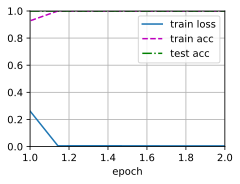

In [50]:
train_fine_tuning(finetune_net, 5e-5)

Probar el modelo por lo menos con tres configuraciones de parámetros.

Crear los gráficos de entrenamiento, donde se vea el error en los conjuntos de train y test durante cada época de entrenamiento.

Crear matriz de clasificación del modelo que presento el menor error en la clasificación, por lo tanto la mejor clasificación.